# importing libraris

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors


from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            recall_score, precision_score, f1_score,
                            confusion_matrix)
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample

from sklearn import preprocessing
from sklearn.impute import KNNImputer
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from category_encoders import TargetEncoder

from sklearn.pipeline import Pipeline
import shap
shap.initjs()

# Data cleaning

In [2]:
datatrain=pd.read_csv('train_dataset.csv')
dataxtest=pd.read_csv('x_test.csv')
dataytest=pd.read_csv('y_test.csv')
datatrain['year_built']=datatrain['year_built'].replace(0.0,np.NaN)
datatrain['energy_star_rating']=datatrain['energy_star_rating'].replace(0.0,np.NaN)
dataxtest['year_built']=dataxtest['year_built'].replace(0.0,np.NaN)
dataxtest['energy_star_rating']=dataxtest['energy_star_rating'].replace(0.0,np.NaN)
datatrain['floor_area']=datatrain['floor_area'].div(100.0)
dataxtest['floor_area']=dataxtest['floor_area'].div(100.0)

# Basics

In [3]:
datatrain

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,612.42,1942.0,11.0,2.4,36,50.500000,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,2740.00,1955.0,45.0,1.8,36,50.500000,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,2800.25,1951.0,97.0,1.8,36,50.500000,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,553.25,1980.0,46.0,1.8,36,50.500000,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,660.00,1985.0,100.0,2.4,36,50.500000,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,6,State_11,Commercial,Office_Uncategorized,204.10,1995.0,8.0,36.6,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,132.918411,75752
75753,6,State_11,Residential,5plus_Unit_Building,404.89,1910.0,98.0,36.6,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,39.483672,75753
75754,6,State_11,Commercial,Commercial_Other,280.72,1917.0,NaN,36.6,26,36.612903,...,6,0,0,0,NaN,NaN,NaN,NaN,48.404398,75754
75755,6,State_11,Commercial,Commercial_Other,535.75,2012.0,NaN,36.6,26,36.612903,...,6,0,0,0,NaN,NaN,NaN,NaN,592.022750,75755


In [4]:
dataxtest

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,7,State_1,Commercial,Grocery_store_or_food_market,284.84,1994.0,37.0,2.4,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75757
1,7,State_1,Commercial,Grocery_store_or_food_market,219.06,1961.0,55.0,45.7,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75758
2,7,State_1,Commercial,Grocery_store_or_food_market,161.38,1950.0,1.0,59.1,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75759
3,7,State_1,Commercial,Grocery_store_or_food_market,974.22,1971.0,34.0,35.4,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75760
4,7,State_1,Commercial,Grocery_store_or_food_market,612.42,1942.0,35.0,1.8,38,50.596774,...,0,29,5,2,0,340.0,330.0,22.8,126.0,75761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,7,State_11,Residential,5plus_Unit_Building,3059.25,2013.0,99.0,812.0,21,38.661290,...,0,39,3,0,0,NaN,NaN,NaN,NaN,85457
9701,7,State_11,Residential,5plus_Unit_Building,349.09,1910.0,94.0,26.5,21,38.661290,...,0,39,3,0,0,NaN,NaN,NaN,NaN,85458
9702,7,State_11,Residential,5plus_Unit_Building,423.93,2014.0,94.0,812.0,21,38.661290,...,0,39,3,0,0,NaN,NaN,NaN,NaN,85459
9703,7,State_11,Residential,5plus_Unit_Building,253.68,1992.0,79.0,812.0,21,38.661290,...,0,39,3,0,0,NaN,NaN,NaN,NaN,85460


In [5]:
datatrain.columns.difference(dataxtest.columns)

Index(['site_eui'], dtype='object')

In [6]:
datatrain.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

In [7]:
datatrain.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73914 non-null  float64
 6   energy_star_rating         49047 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [8]:
datatrain.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Year_Factor,75757.0,NaN,NaN,NaN,4.367755,1.471441,1.0,3.0,5.0,6.0,6.0
State_Factor,75757,7,State_6,50840,NaN,NaN,NaN,NaN,NaN,NaN,NaN
building_class,75757,2,Residential,43558,NaN,NaN,NaN,NaN,NaN,NaN,NaN
facility_type,75757,60,Multifamily_Uncategorized,39455,NaN,NaN,NaN,NaN,NaN,NaN,NaN
floor_area,75757.0,NaN,NaN,NaN,1659.838659,2468.757909,9.43,623.79,913.67,1660.0,63853.82
...,...,...,...,...,...,...,...,...,...,...,...
direction_peak_wind_speed,33946.0,NaN,NaN,NaN,62.779974,130.308106,1.0,1.0,1.0,1.0,360.0
max_wind_speed,34675.0,NaN,NaN,NaN,4.190601,6.458789,1.0,1.0,1.0,1.0,23.3
days_with_fog,29961.0,NaN,NaN,NaN,109.142051,50.699751,12.0,88.0,104.0,131.0,311.0
site_eui,75757.0,NaN,NaN,NaN,82.584693,58.255403,1.001169,54.528601,75.293716,97.277534,997.86612


In [9]:
print(datatrain.duplicated().sum())
print(dataxtest.duplicated().sum())

0
0


In [10]:
print(datatrain.isnull().sum().to_string())

Year_Factor                      0
State_Factor                     0
building_class                   0
facility_type                    0
floor_area                       0
year_built                    1843
energy_star_rating           26710
ELEVATION                        0
january_min_temp                 0
january_avg_temp                 0
january_max_temp                 0
february_min_temp                0
february_avg_temp                0
february_max_temp                0
march_min_temp                   0
march_avg_temp                   0
march_max_temp                   0
april_min_temp                   0
april_avg_temp                   0
april_max_temp                   0
may_min_temp                     0
may_avg_temp                     0
may_max_temp                     0
june_min_temp                    0
june_avg_temp                    0
june_max_temp                    0
july_min_temp                    0
july_avg_temp                    0
july_max_temp       

In [11]:
print(dataxtest.isnull().sum().to_string())

Year_Factor                     0
State_Factor                    0
building_class                  0
facility_type                   0
floor_area                      0
year_built                     93
energy_star_rating           2254
ELEVATION                       0
january_min_temp                0
january_avg_temp                0
january_max_temp                0
february_min_temp               0
february_avg_temp               0
february_max_temp               0
march_min_temp                  0
march_avg_temp                  0
march_max_temp                  0
april_min_temp                  0
april_avg_temp                  0
april_max_temp                  0
may_min_temp                    0
may_avg_temp                    0
may_max_temp                    0
june_min_temp                   0
june_avg_temp                   0
june_max_temp                   0
july_min_temp                   0
july_avg_temp                   0
july_max_temp                   0
august_min_tem

In [12]:
categorycols=['State_Factor','building_class','facility_type']

In [13]:
nullcols=[col for col in datatrain.columns if datatrain[col].isnull().sum() > 0]
print(nullcols)

['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']


In [14]:
# constant features

print([col for col in datatrain if datatrain[col].nunique()==1])
print([col for col in dataxtest if dataxtest[col].nunique()==1])

[]
['Year_Factor', 'days_above_110F']


# EDA

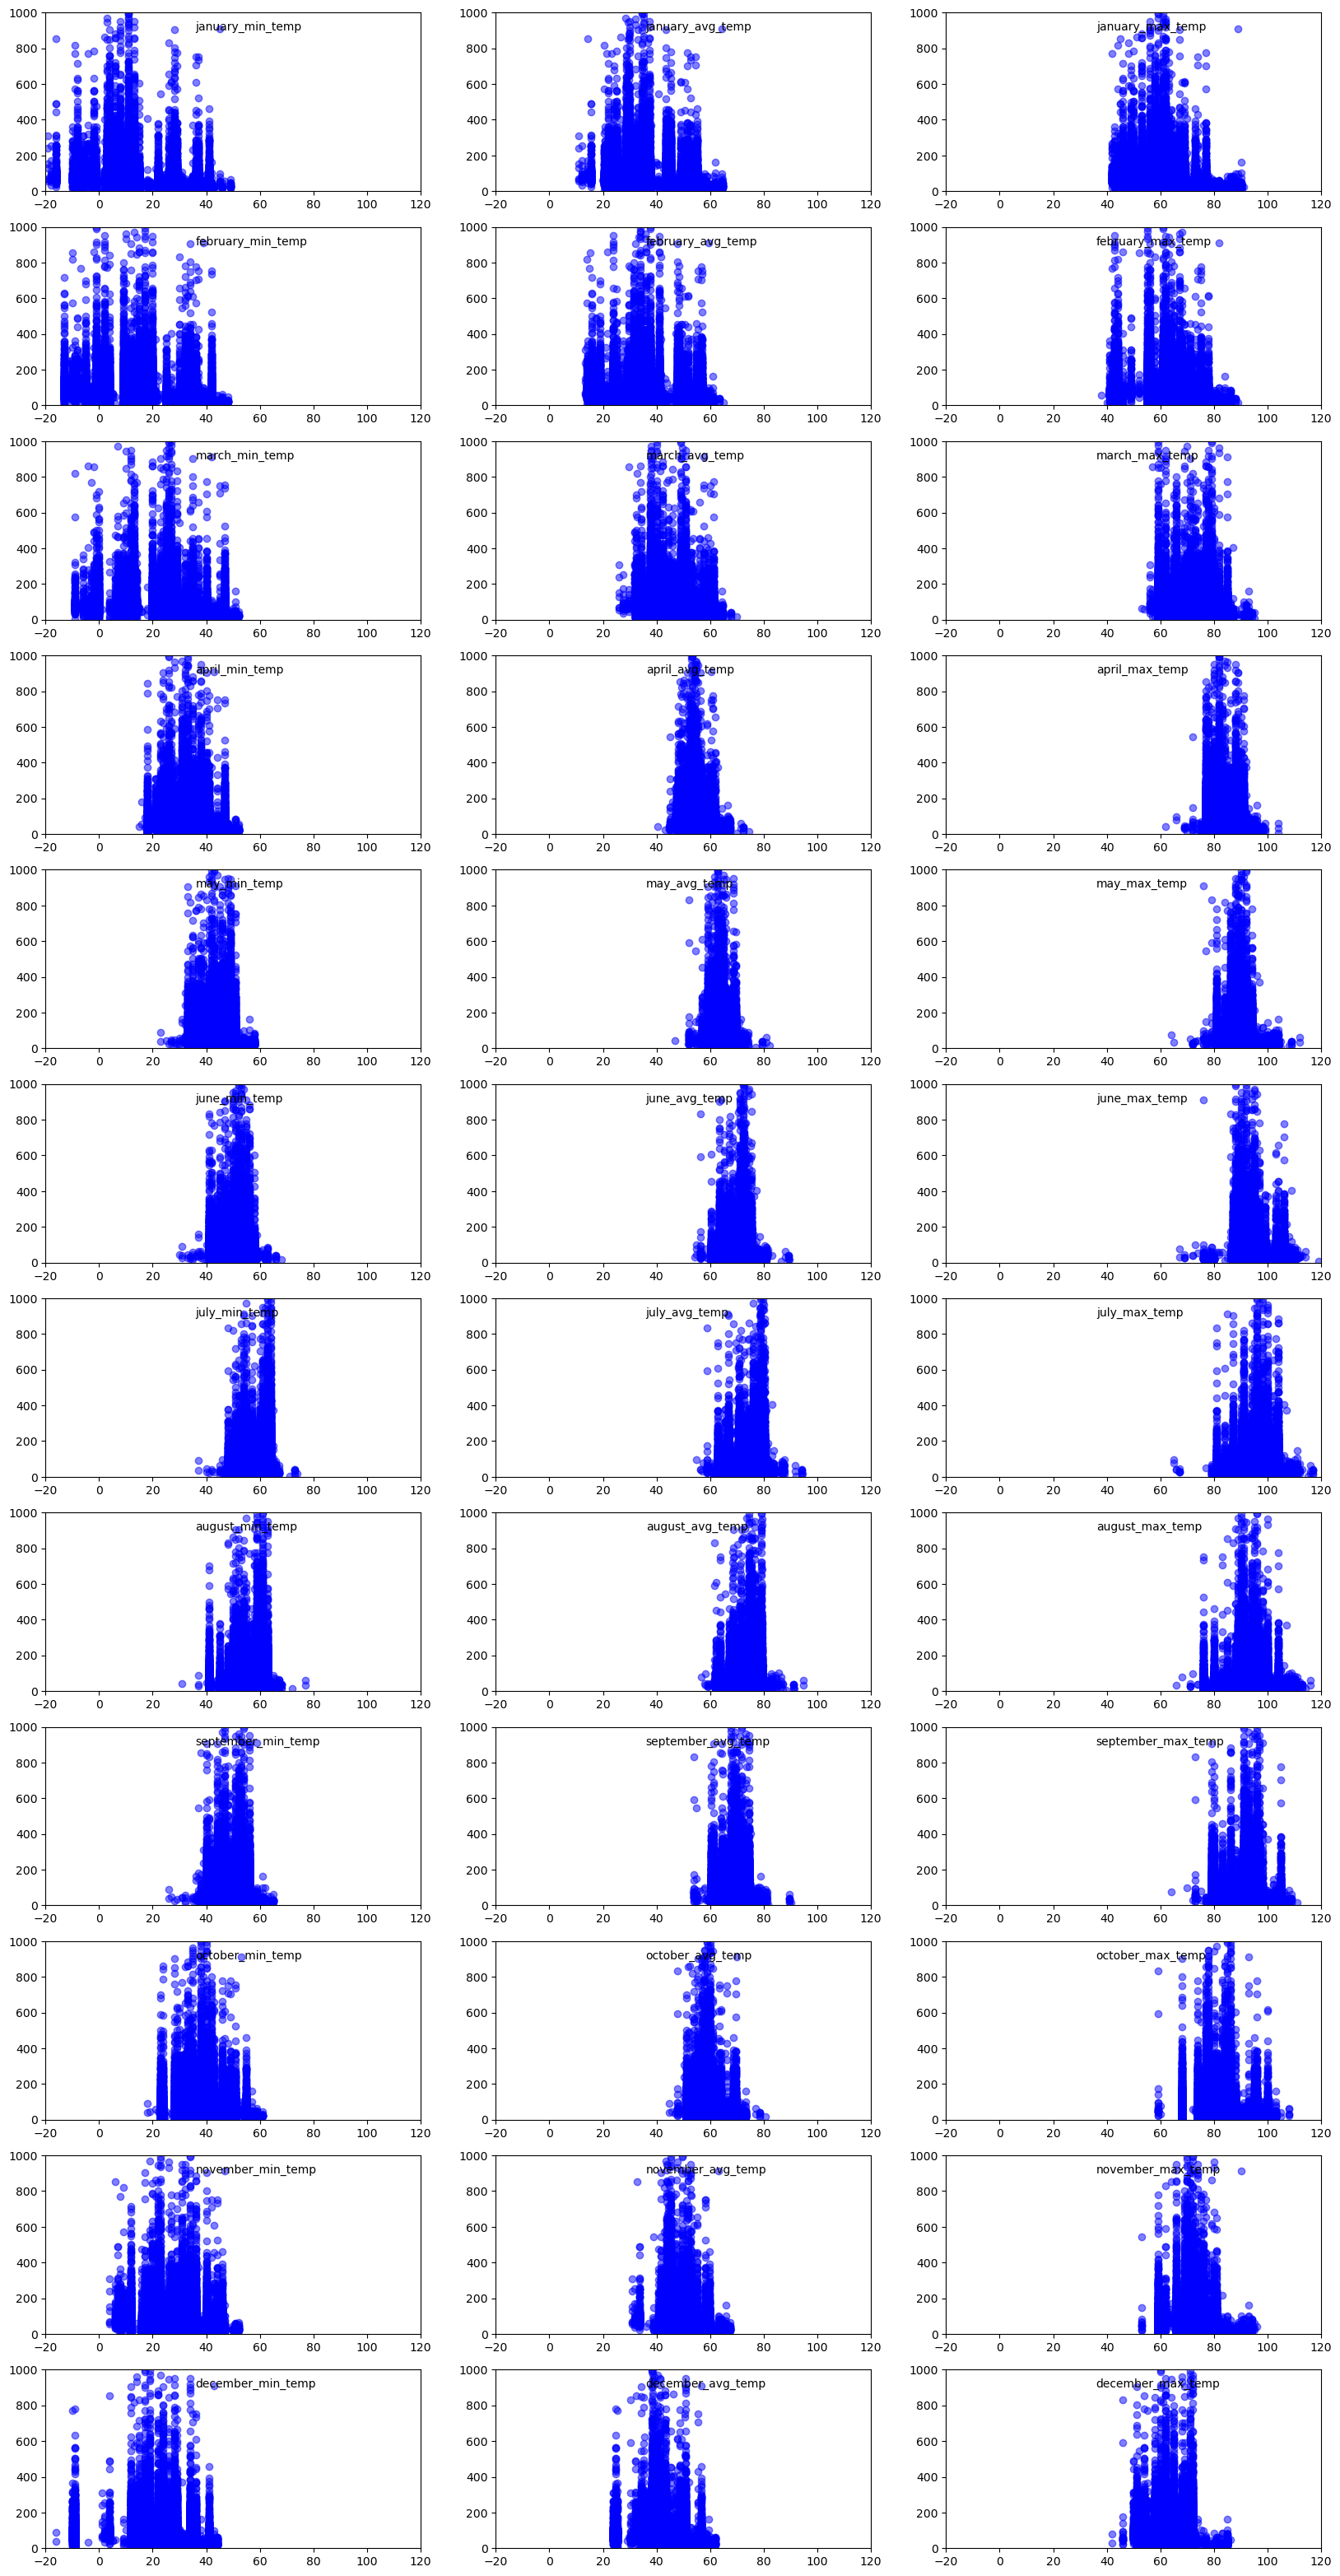

In [15]:
plotdata=datatrain[datatrain.columns[8:44]]
fig,ax=plt.subplots(12,3,figsize=(20,40))
for ind,cols in enumerate(plotdata.columns): 
    xd=plotdata[cols]
    yd=datatrain['site_eui']
    i=int(ind/3)
    j=np.mod(ind,3)
    ax[i,j].scatter(xd,yd,c='blue',alpha=0.5)
    ax[i,j].set_xlim([-20,120])
    ax[i,j].set_ylim([0,1000])
    ax[i,j].text(0.4,0.9,cols,transform=ax[i,j].transAxes)

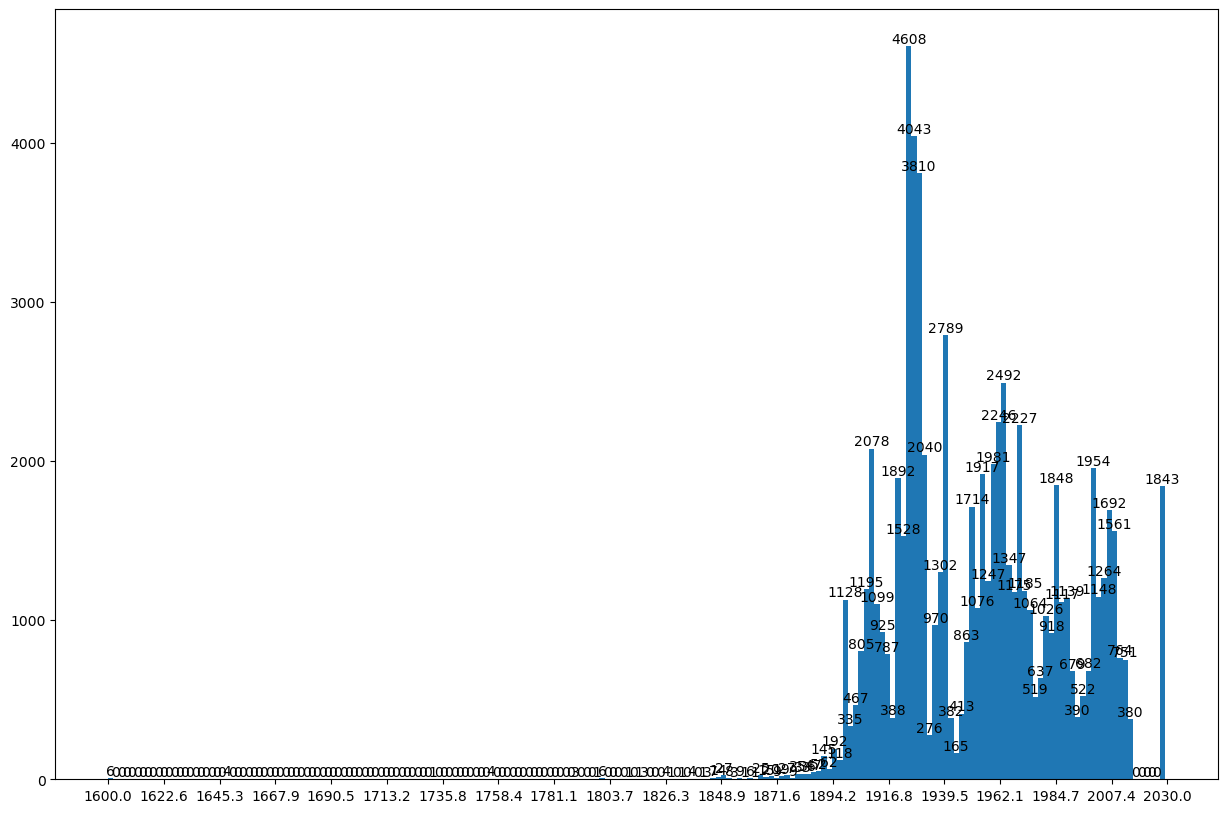

In [16]:
plotdata=pd.DataFrame()
plotdata = datatrain['year_built'].fillna(value=2029)

fig, ax = plt.subplots(figsize=(15,10))
counts,edges,bars=ax.hist(plotdata,bins=200)
ax.set_xticks(np.linspace(1600,2030,20))
ax=plt.bar_label(bars)


### correlation if any

<AxesSubplot:>

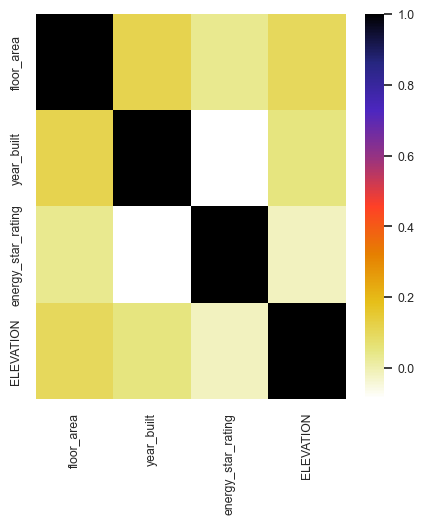

In [17]:
plotdata=pd.DataFrame()
plotcols=['floor_area', 'year_built', 'energy_star_rating', 'ELEVATION']
plotdata=datatrain[plotcols]
plt.figure(figsize=(5,5))
sns.set(font_scale=0.8)
sns.heatmap(plotdata.corr(),  cmap=plt.cm.CMRmap_r)

# Category columns

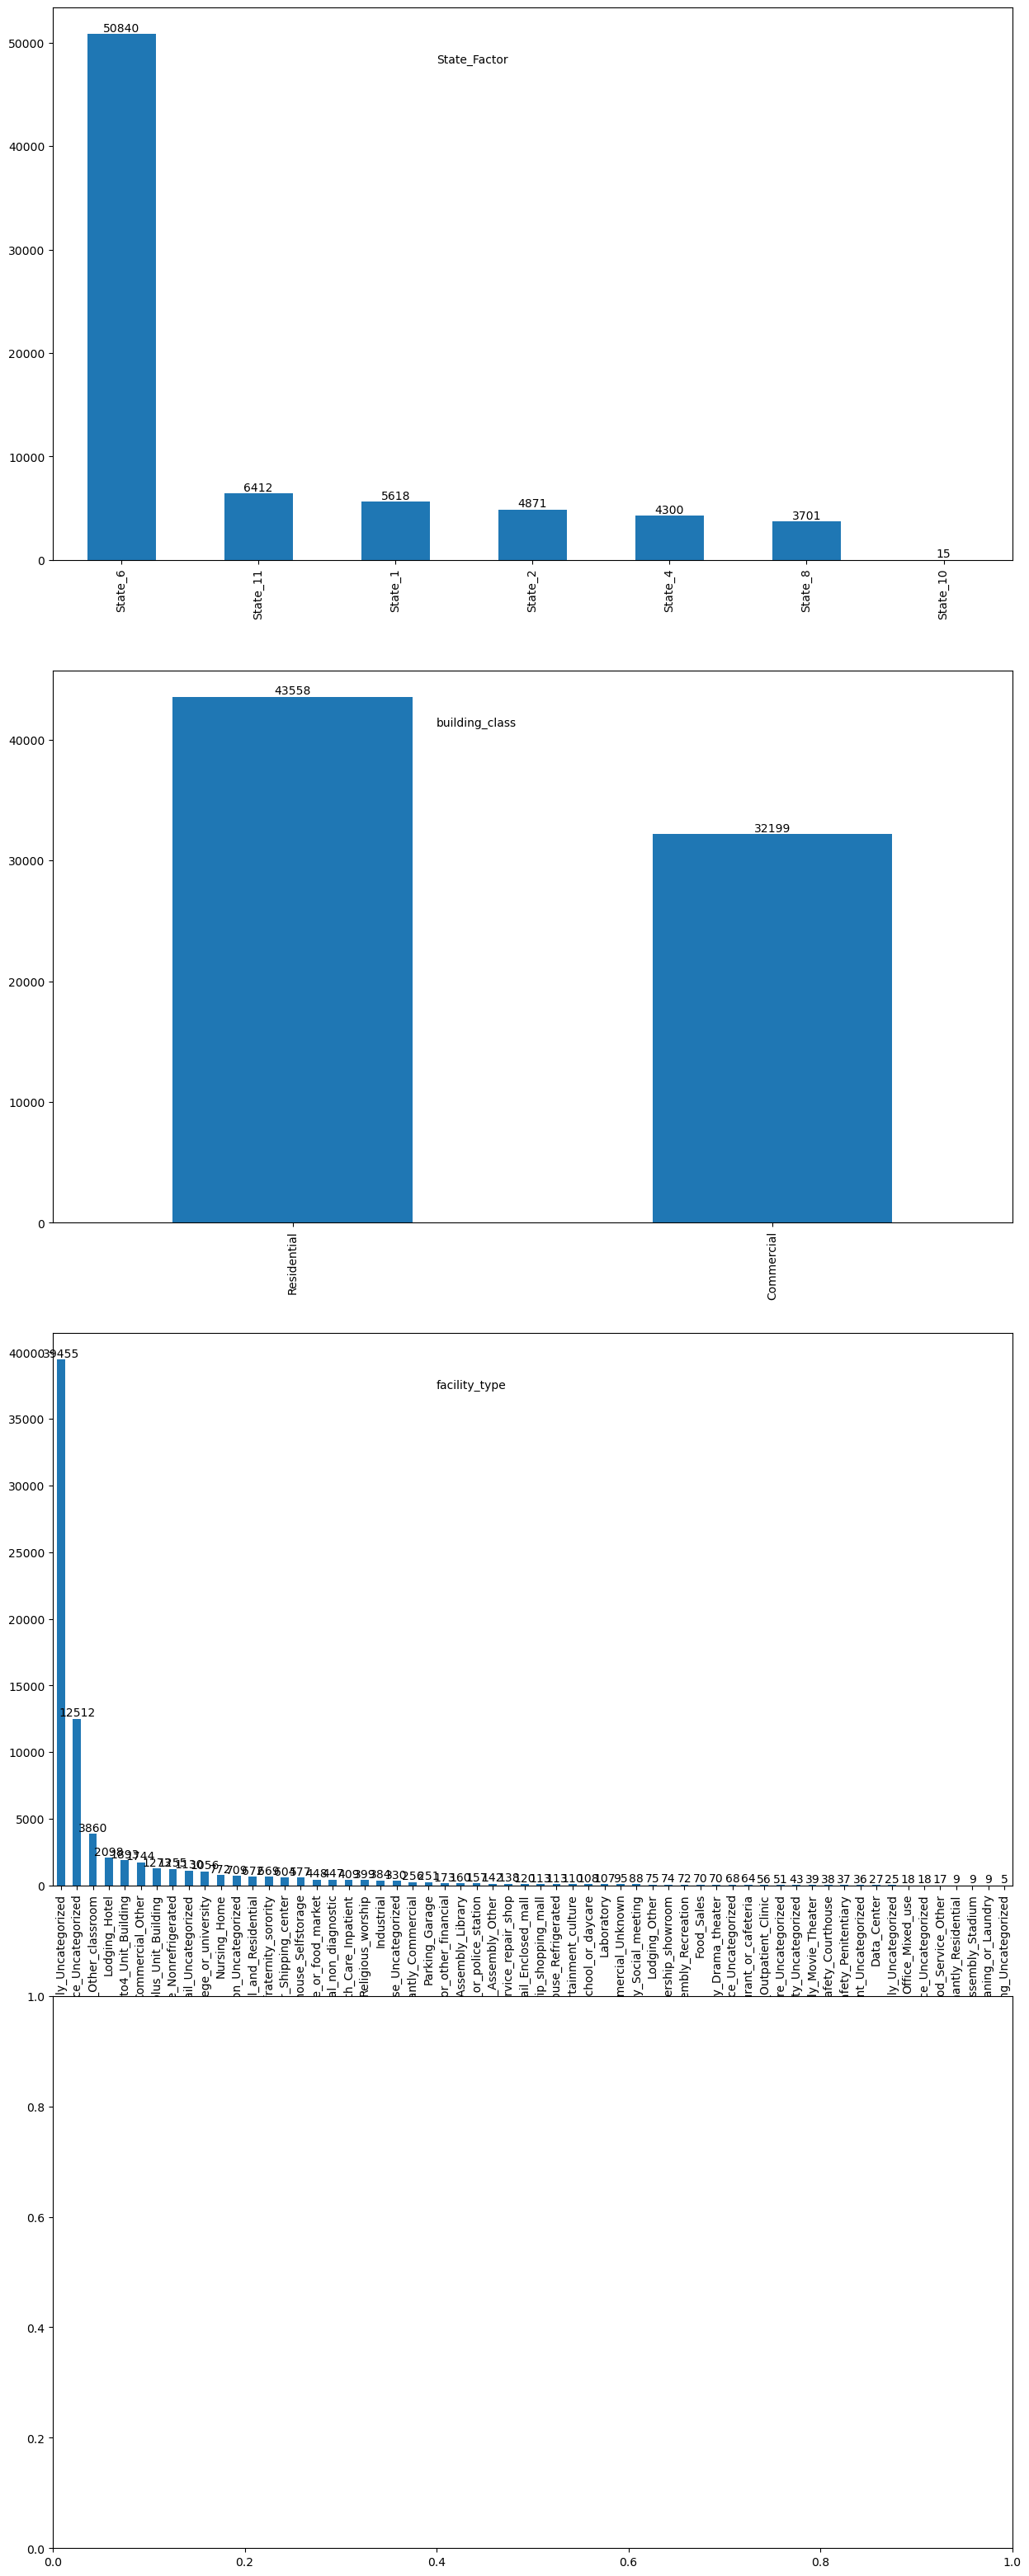

In [15]:
plotdata=pd.DataFrame()
plotdata=datatrain[categorycols]
fig,ax=plt.subplots(4,1,figsize=(15,40),sharex=False)
for ind,val in enumerate(plotdata.columns):
    plotdata[val].value_counts().plot(kind='bar',ax=ax[ind])
    ax[ind].bar_label(ax[ind].containers[0])
    ax[ind].text(0.4,0.9,val,transform=ax[ind].transAxes)
#
#ax[0]=plotdata['Year_Factor'].value_counts().plot(kind='bar')
#datatrain[categorycols[0]].value_counts().plot(kind='bar')

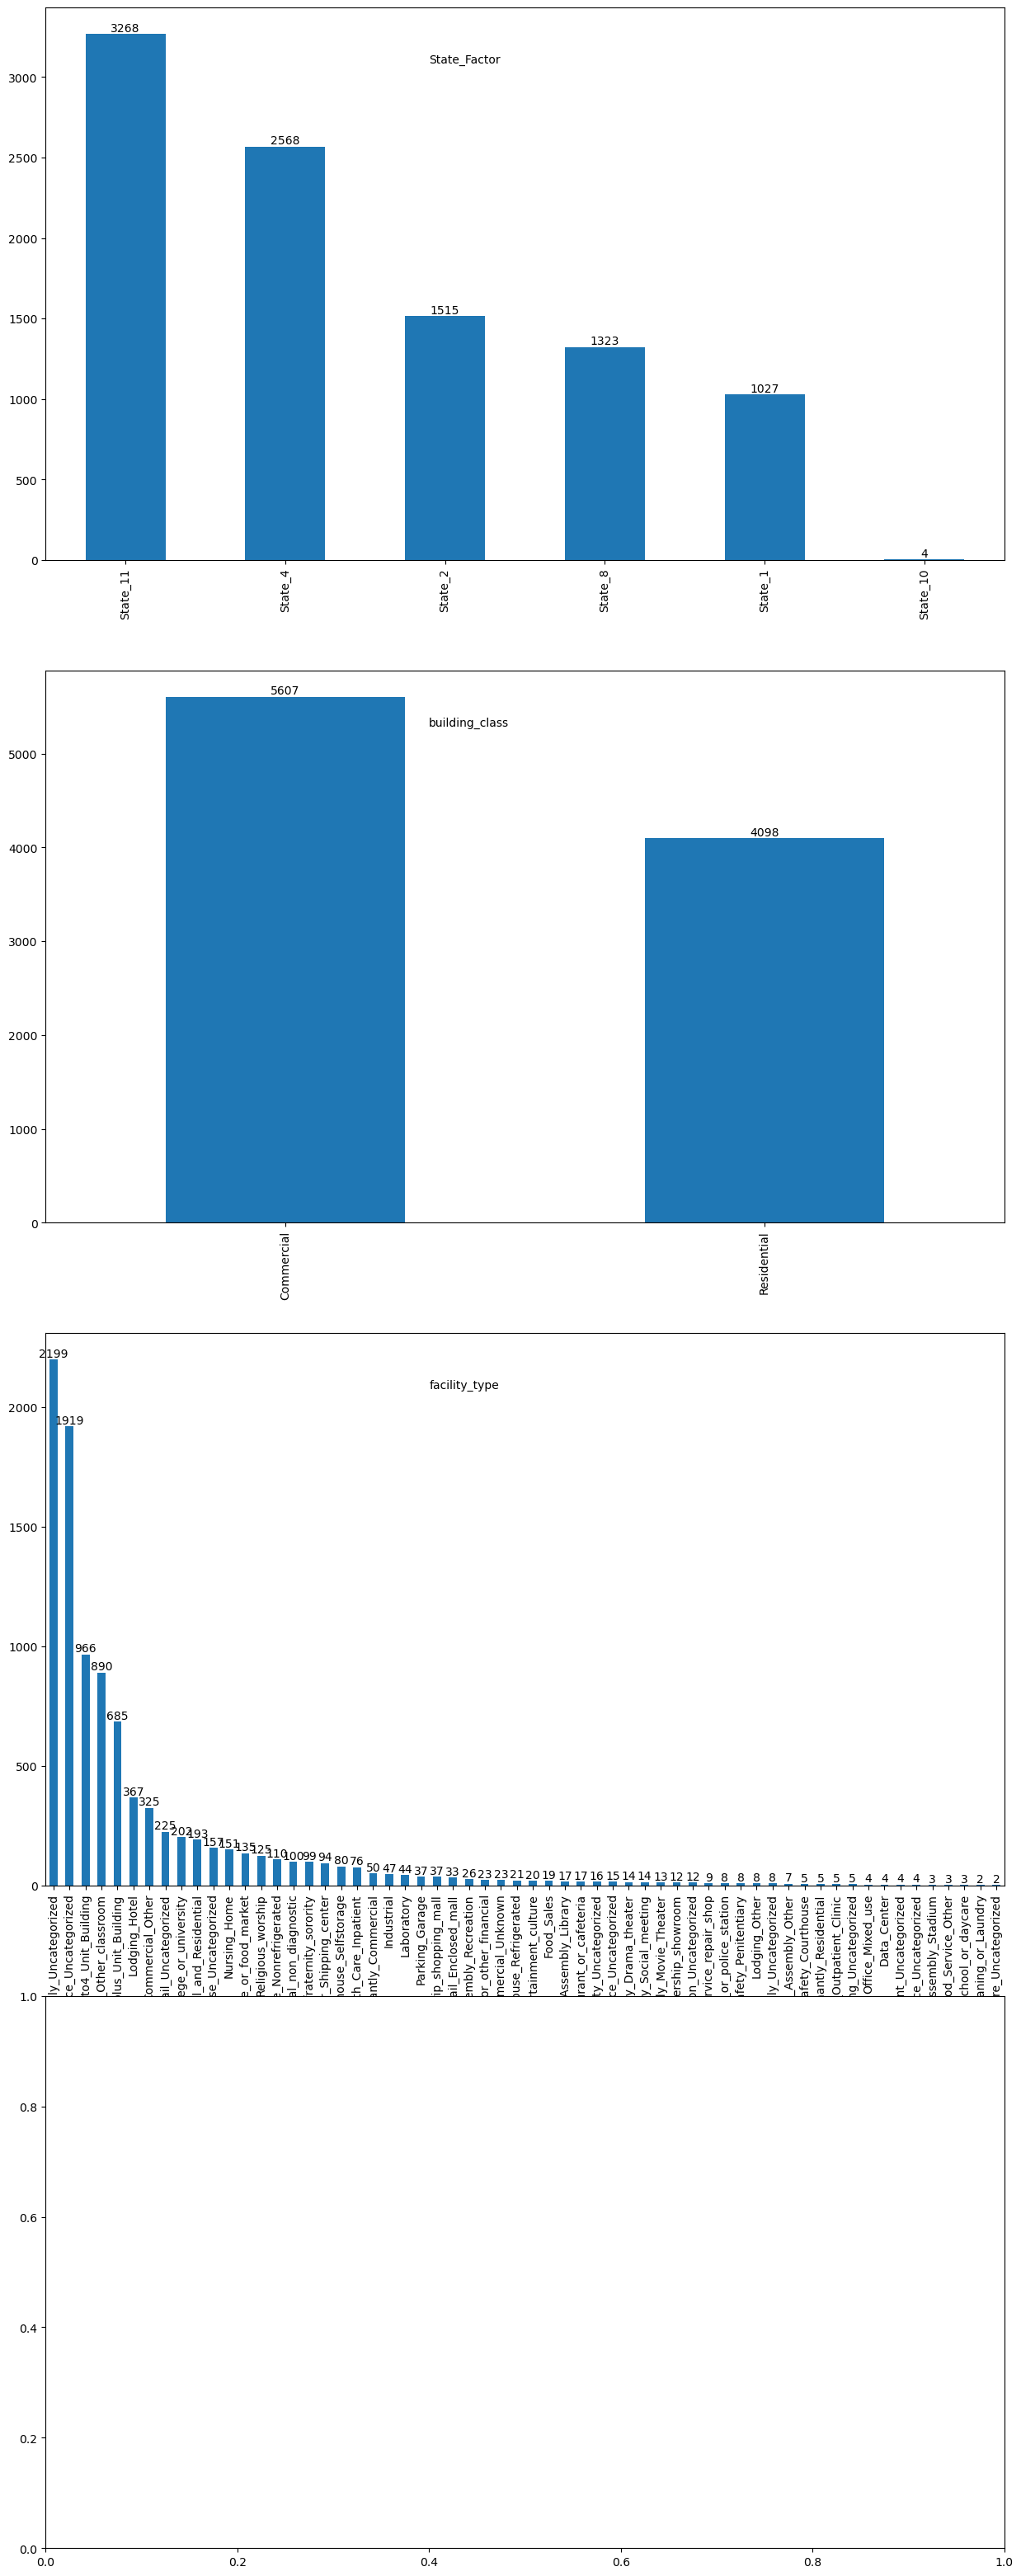

In [16]:
plotdata=pd.DataFrame()
plotdata=dataxtest[categorycols]
fig,ax=plt.subplots(4,1,figsize=(15,40),sharex=False)
for ind,val in enumerate(plotdata.columns):
    plotdata[val].value_counts().plot(kind='bar',ax=ax[ind])
    ax[ind].bar_label(ax[ind].containers[0])
    ax[ind].text(0.4,0.9,val,transform=ax[ind].transAxes)

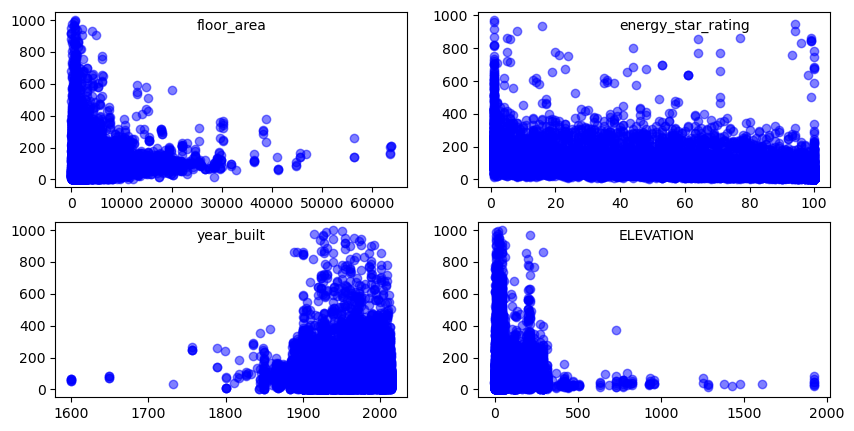

In [17]:
plotdata=datatrain[['floor_area','energy_star_rating','year_built','ELEVATION']]
fig,ax=plt.subplots(2,2,figsize=(10,5))
for ind,cols in enumerate(plotdata.columns): 
    xd=plotdata[cols]
    yd=datatrain['site_eui']
    i=int(ind/2)
    j=np.mod(ind,2)
    ax[i,j].scatter(xd,yd,c='blue',alpha=0.5)
    ax[i,j].text(0.4,0.9,cols,transform=ax[i,j].transAxes)

### These features are non-linear functions of site_eui, therefore we should using non-linear regression like Decision tree, plus there are categorical features as well

# Preprocessing

In [18]:
print(nullcols)
print(categorycols)

['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
['State_Factor', 'building_class', 'facility_type']


# Removing features with >50% null values

In [19]:

datatrain=datatrain.drop(['direction_max_wind_speed','direction_peak_wind_speed',
             'max_wind_speed','days_with_fog'],axis=1)
dataxtest=dataxtest.drop(['direction_max_wind_speed','direction_peak_wind_speed',
             'max_wind_speed','days_with_fog'],axis=1)

# Baseline modeling 

In [20]:
catb = CatBoostRegressor(iterations=3000,
                 learning_rate=0.03,
                 depth=7,
                 loss_function='RMSE',verbose=1,
                 l2_leaf_reg=0.05,
                )
catb.fit(datatrain.drop(['site_eui','id'],axis=1),datatrain['site_eui'],cat_features=categorycols)

0:	learn: 57.7914840	total: 192ms	remaining: 9m 35s
1:	learn: 57.2757554	total: 241ms	remaining: 6m 1s
2:	learn: 56.8456470	total: 288ms	remaining: 4m 48s
3:	learn: 56.4456906	total: 343ms	remaining: 4m 16s
4:	learn: 55.9856468	total: 390ms	remaining: 3m 53s
5:	learn: 55.6404830	total: 439ms	remaining: 3m 38s
6:	learn: 55.2603993	total: 488ms	remaining: 3m 28s
7:	learn: 54.9365579	total: 533ms	remaining: 3m 19s
8:	learn: 54.6200937	total: 580ms	remaining: 3m 12s
9:	learn: 54.2920651	total: 628ms	remaining: 3m 7s
10:	learn: 53.9826868	total: 674ms	remaining: 3m 3s
11:	learn: 53.6505038	total: 722ms	remaining: 2m 59s
12:	learn: 53.3739787	total: 773ms	remaining: 2m 57s
13:	learn: 53.0619426	total: 821ms	remaining: 2m 55s
14:	learn: 52.7454832	total: 869ms	remaining: 2m 52s
15:	learn: 52.5239447	total: 920ms	remaining: 2m 51s
16:	learn: 52.2473516	total: 969ms	remaining: 2m 49s
17:	learn: 51.9773258	total: 1.02s	remaining: 2m 49s
18:	learn: 51.7619418	total: 1.07s	remaining: 2m 48s
19:	le

In [21]:
ypred=catb.predict(dataxtest.drop(['id'],axis=1))
rms = mean_squared_error(dataytest['site_eui'], ypred, squared=False)
print(rms)

42.23228627931223


### Need to perform better than 43.8 rmse, we are overfitting since RMSE in train data is ~33 but RMSE in test is ~43.8

In [22]:
datatrainimp=pd.DataFrame(datatrain)
dataxtestimp=pd.DataFrame(dataxtest)

In [23]:
print(datatrainimp.columns)

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

# Imputing missing values using KNN imputer

In [24]:
nullimp = KNNImputer(n_neighbors=7)
datatrainimpute = pd.DataFrame(nullimp.fit_transform(datatrainimp.drop(categorycols+['site_eui'],axis=1)),columns = datatrainimp.drop(categorycols+['site_eui'],axis=1).columns)
dataxtestimpute = pd.DataFrame(nullimp.transform(dataxtestimp.drop(categorycols,axis=1)),columns = dataxtestimp.drop(categorycols,axis=1).columns)


In [25]:
datatrain=pd.DataFrame()
dataxtest=pd.DataFrame()

datatrain=pd.concat([datatrainimp[categorycols],datatrainimpute,datatrainimp['site_eui']],axis=1)
dataxtest=pd.concat([dataxtestimp[categorycols],dataxtestimpute],axis=1)


# Feature engineering

In [26]:
summonthmin = [col for col in datatrain.columns if 'may' in col or 'jun' in col or 'jul' in col if 'min' in col]
winmonthmin = [col for col in datatrain.columns if 'nov' in col or 'dec' in col or 'jan' in col if 'min' in col ]
autmonthmin = [col for col in datatrain.columns if 'aug' in col or 'sep' in col or 'oct' in col if 'min' in col ]
sprmonthmin = [col for col in datatrain.columns if 'feb' in col or 'mar' in col or 'apr' in col if 'min' in col ]

summonthmax = [col for col in datatrain.columns if 'may' in col or 'jun' in col or 'jul' in col if 'max' in col]
winmonthmax = [col for col in datatrain.columns if 'nov' in col or 'dec' in col or 'jan' in col if 'max' in col ]
autmonthmax = [col for col in datatrain.columns if 'aug' in col or 'sep' in col or 'oct' in col if 'max' in col ]
sprmonthmax = [col for col in datatrain.columns if 'feb' in col or 'mar' in col or 'apr' in col if 'max' in col ]

summonthavg = [col for col in datatrain.columns if 'may' in col or 'jun' in col or 'jul' in col if 'avg' in col]
winmonthavg = [col for col in datatrain.columns if 'nov' in col or 'dec' in col or 'jan' in col if 'avg' in col ]
autmonthavg = [col for col in datatrain.columns if 'aug' in col or 'sep' in col or 'oct' in col if 'avg' in col ]
sprmonthavg = [col for col in datatrain.columns if 'feb' in col or 'mar' in col or 'apr' in col if 'avg' in col ]


In [27]:
newdatatrain=pd.DataFrame(datatrain)
newdatatrain['summonth_min']=newdatatrain[summonthmin].min(axis=1)
newdatatrain['winmonth_min']=newdatatrain[winmonthmin].min(axis=1)
newdatatrain['autmonth_min']=newdatatrain[autmonthmin].min(axis=1)
newdatatrain['sprmonth_min']=newdatatrain[sprmonthmin].min(axis=1)

newdatatrain['summonth_max']=newdatatrain[summonthmax].max(axis=1)
newdatatrain['winmonth_max']=newdatatrain[winmonthmax].max(axis=1)
newdatatrain['autmonth_max']=newdatatrain[autmonthmax].max(axis=1)
newdatatrain['sprmonth_max']=newdatatrain[sprmonthmax].max(axis=1)

newdatatrain['summonth_avg']=newdatatrain[summonthavg].mean(axis=1)
newdatatrain['winmonth_avg']=newdatatrain[winmonthavg].mean(axis=1)
newdatatrain['autmonth_avg']=newdatatrain[autmonthavg].mean(axis=1)
newdatatrain['sprmonth_avg']=newdatatrain[sprmonthavg].mean(axis=1)


newdataxtest=pd.DataFrame(dataxtest)
newdataxtest['summonth_min']=newdataxtest[summonthmin].min(axis=1)
newdataxtest['winmonth_min']=newdataxtest[winmonthmin].min(axis=1)
newdataxtest['autmonth_min']=newdataxtest[autmonthmin].min(axis=1)
newdataxtest['sprmonth_min']=newdataxtest[sprmonthmin].min(axis=1)

newdataxtest['summonth_max']=newdataxtest[summonthmax].max(axis=1)
newdataxtest['winmonth_max']=newdataxtest[winmonthmax].max(axis=1)
newdataxtest['autmonth_max']=newdataxtest[autmonthmax].max(axis=1)
newdataxtest['sprmonth_max']=newdataxtest[sprmonthmax].max(axis=1)

newdataxtest['summonth_avg']=newdataxtest[summonthavg].mean(axis=1)
newdataxtest['winmonth_avg']=newdataxtest[winmonthavg].mean(axis=1)
newdataxtest['autmonth_avg']=newdataxtest[autmonthavg].mean(axis=1)
newdataxtest['sprmonth_avg']=newdataxtest[sprmonthavg].mean(axis=1)

newdatatrain=newdatatrain.drop(summonthavg+winmonthavg+autmonthavg+sprmonthavg,axis=1)
newdatatrain=newdatatrain.drop(summonthmin+winmonthmin+autmonthmin+sprmonthmin,axis=1)
newdatatrain=newdatatrain.drop(summonthmax+winmonthmax+autmonthmax+sprmonthmax,axis=1)
newdataxtest=newdataxtest.drop(summonthavg+winmonthavg+autmonthavg+sprmonthavg,axis=1)
newdataxtest=newdataxtest.drop(summonthmin+winmonthmin+autmonthmin+sprmonthmin,axis=1)
newdataxtest=newdataxtest.drop(summonthmax+winmonthmax+autmonthmax+sprmonthmax,axis=1)

In [28]:
newdatatrain['heatingdays']=newdatatrain['days_above_80F']+newdatatrain['days_above_90F']+ \
                     newdatatrain['days_above_100F']+newdatatrain['days_above_110F']
newdatatrain['coolingdays']=newdatatrain['days_below_0F']+newdatatrain['days_below_10F']+ \
                     newdatatrain['days_below_20F']+newdatatrain['days_below_30F']

newdataxtest['heatingdays']=newdataxtest['days_above_80F']+newdataxtest['days_above_90F']+ \
                     newdataxtest['days_above_100F']+newdataxtest['days_above_110F']
newdataxtest['coolingdays']=newdataxtest['days_below_0F']+newdataxtest['days_below_10F']+ \
                     newdataxtest['days_below_20F']+newdataxtest['days_below_30F']


newdatatrain['buildingvolume']=newdatatrain['ELEVATION']*newdatatrain['floor_area']
newdataxtest['buildingvolume']=newdataxtest['ELEVATION']*newdataxtest['floor_area']


newdatatrain=newdatatrain.drop([col for col in newdatatrain.columns if 'days_above' in col],axis=1)
newdatatrain=newdatatrain.drop([col for col in newdatatrain.columns if 'days_below' in col],axis=1)
newdataxtest=newdataxtest.drop([col for col in newdataxtest.columns if 'days_above' in col],axis=1)
newdataxtest=newdataxtest.drop([col for col in newdataxtest.columns if 'days_below' in col],axis=1)



newdatatrain=newdatatrain.drop(['precipitation_inches','snowfall_inches','snowdepth_inches'],axis=1)
newdataxtest=newdataxtest.drop(['precipitation_inches','snowfall_inches','snowdepth_inches'],axis=1)

In [29]:
newdatatrain.describe().T

,count,mean,std,min,25%,50%,75%,max
Year_Factor,75757.0,4.367755,1.471441,1.000000,3.000000,5.000000,6.000000,6.000000e+00
floor_area,75757.0,1659.838659,2468.757909,9.430000,623.790000,913.670000,1660.000000,6.385382e+04
year_built,75757.0,1952.447004,32.320356,1600.000000,1927.000000,1952.000000,1976.000000,2.015000e+03
energy_star_rating,75757.0,60.636811,24.347631,1.000000,46.142857,63.000000,79.000000,1.000000e+02
ELEVATION,75757.0,39.506323,60.656596,-6.400000,11.900000,25.000000,42.700000,1.924500e+03
cooling_degree_days,75757.0,1202.250446,391.561780,0.000000,1128.000000,1277.000000,1489.000000,4.948000e+03
heating_degree_days,75757.0,4324.957390,824.366727,398.000000,3978.000000,4337.000000,4670.000000,7.929000e+03
avg_temp,75757.0,56.176705,2.241940,44.512329,55.147541,56.835616,57.215847,7.724521e+01
id,75757.0,37878.000000,21869.306509,0.000000,18939.000000,37878.000000,56817.000000,7.575600e+04
site_eui,75757.0,82.584693,58.255403,1.001169,54.528601,75.293716,97.277534,9.978661e+02


In [30]:
newdatatrain.columns

Index(['State_Factor', 'building_class', 'facility_type', 'Year_Factor',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'cooling_degree_days', 'heating_degree_days', 'avg_temp', 'id',
       'site_eui', 'summonth_min', 'winmonth_min', 'autmonth_min',
       'sprmonth_min', 'summonth_max', 'winmonth_max', 'autmonth_max',
       'sprmonth_max', 'summonth_avg', 'winmonth_avg', 'autmonth_avg',
       'sprmonth_avg', 'heatingdays', 'coolingdays', 'buildingvolume'],
      dtype='object')

# Final fit

In [31]:
catb = CatBoostRegressor(iterations=4000,
                         learning_rate=0.03,
                         depth=12,
                         loss_function='RMSE',verbose=1,
                         l2_leaf_reg=0.05
                        )
catb.fit(newdatatrain.drop(['site_eui','id'],axis=1),newdatatrain['site_eui'],cat_features=categorycols)

0:	learn: 57.6515555	total: 261ms	remaining: 17m 25s
1:	learn: 57.0542958	total: 516ms	remaining: 17m 11s
2:	learn: 56.4848494	total: 766ms	remaining: 17m
3:	learn: 55.9418665	total: 1.01s	remaining: 16m 48s
4:	learn: 55.4124331	total: 1.26s	remaining: 16m 49s
5:	learn: 54.8984202	total: 1.51s	remaining: 16m 45s
6:	learn: 54.4491472	total: 1.76s	remaining: 16m 46s
7:	learn: 54.0099625	total: 2.01s	remaining: 16m 43s
8:	learn: 53.5669720	total: 2.25s	remaining: 16m 39s
9:	learn: 53.1676338	total: 2.52s	remaining: 16m 47s
10:	learn: 52.7562896	total: 2.77s	remaining: 16m 43s
11:	learn: 52.3489951	total: 3.02s	remaining: 16m 42s
12:	learn: 51.9848690	total: 3.3s	remaining: 16m 52s
13:	learn: 51.6333412	total: 3.54s	remaining: 16m 47s
14:	learn: 51.2857618	total: 3.77s	remaining: 16m 43s
15:	learn: 50.9496726	total: 4.02s	remaining: 16m 40s
16:	learn: 50.6120628	total: 4.28s	remaining: 16m 41s
17:	learn: 50.3009312	total: 4.53s	remaining: 16m 41s
18:	learn: 50.0204547	total: 4.77s	remainin

In [32]:
ypred=catb.predict(newdataxtest.drop(['id'],axis=1))
rms = mean_squared_error(dataytest['site_eui'], ypred, squared=False)
print(rms)

36.148947074901095


### We are getting better RMSE=36.1 rank in the competiton would be 401 out of  829 , but we are still overfitting because RMSE in fitting is ~18.0 
### Can work on how we impute the data, taking the train data and impute by grouping the data with similar categorical features
### Using hyperparameter tuning to fine tune this fit
### This rmse would put us at a rank of ~450 out of 1000 people in the competition 
### Using XGBoost or XTree maybe have some effect on RMSE but won't matter much
### I tried a bunch of other things like imputing the values by fitting the nonnull data to the null data to predict the null valued features, tried different feature engineerings etc. but they don't improve the results much

# Feature importance using SHAP and inbuilt catboost function

Text(0.5, 1.0, 'Feature Importance')

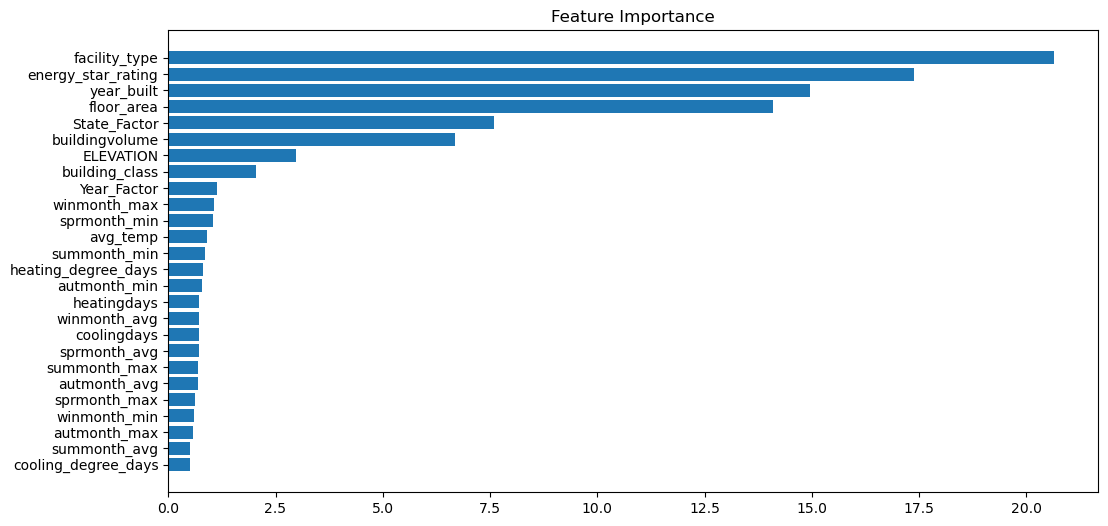

In [33]:
feature_importance = catb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(newdataxtest.drop(['id'],axis=1).columns)[sorted_idx])
plt.title('Feature Importance')


In [37]:
explainer = shap.TreeExplainer(catb)
shap_values = explainer.shap_values(newdatatrain.drop(['site_eui','id'],axis=1))
shap.summary_plot(shap_values, newdatatrain.drop(['site_eui','id'],axis=1), plot_type="bar")

### The categorical columns are very important 
### The temperature based features don't play much part
### Energy star rating and year built which was had high null values in the train dataset has much higher importance in the model fitting

# Saving model for web app

In [ ]:
import joblib 

In [46]:
filename = 'catboostenergypredictormodel.sav'
catb.save_model(filename)
 

catbb = CatBoostRegressor(cat_features=categorycols)
# load the model from disk
catbb.load_model(filename)
ypred=catbb.predict(newdataxtest.drop(['id'],axis=1))
result = mean_squared_error(dataytest['site_eui'], ypred, squared=False)
print(result)

CatBoostError: (Access is denied.) C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/util/system/file.cpp:992: can't write 262094840 bytes to "catboostenergypredictormodel.sav"

In [38]:
print(newdatatrain['State_Factor'].unique())
print(newdataxtest['State_Factor'].unique())

['State_1' 'State_2' 'State_4' 'State_6' 'State_8' 'State_10' 'State_11']
['State_1' 'State_2' 'State_4' 'State_8' 'State_11' 'State_10']


In [40]:
print([newdatatrain['facility_type'].unique()])

[array(['Grocery_store_or_food_market',
       'Warehouse_Distribution_or_Shipping_center',
       'Retail_Enclosed_mall', 'Education_Other_classroom',
       'Warehouse_Nonrefrigerated', 'Warehouse_Selfstorage',
       'Office_Uncategorized', 'Data_Center', 'Commercial_Other',
       'Mixed_Use_Predominantly_Commercial',
       'Office_Medical_non_diagnostic', 'Education_College_or_university',
       'Industrial', 'Laboratory',
       'Public_Assembly_Entertainment_culture',
       'Retail_Vehicle_dealership_showroom', 'Retail_Uncategorized',
       'Lodging_Hotel', 'Retail_Strip_shopping_mall',
       'Education_Uncategorized', 'Health_Care_Inpatient',
       'Public_Assembly_Drama_theater', 'Public_Assembly_Social_meeting',
       'Religious_worship', 'Mixed_Use_Commercial_and_Residential',
       'Office_Bank_or_other_financial', 'Parking_Garage',
       'Commercial_Unknown', 'Service_Vehicle_service_repair_shop',
       'Service_Drycleaning_or_Laundry', 'Public_Assembly_Recreatio

In [41]:
newdatatrain.columns

Index(['State_Factor', 'building_class', 'facility_type', 'Year_Factor',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'cooling_degree_days', 'heating_degree_days', 'avg_temp', 'id',
       'site_eui', 'summonth_min', 'winmonth_min', 'autmonth_min',
       'sprmonth_min', 'summonth_max', 'winmonth_max', 'autmonth_max',
       'sprmonth_max', 'summonth_avg', 'winmonth_avg', 'autmonth_avg',
       'sprmonth_avg', 'heatingdays', 'coolingdays', 'buildingvolume'],
      dtype='object')